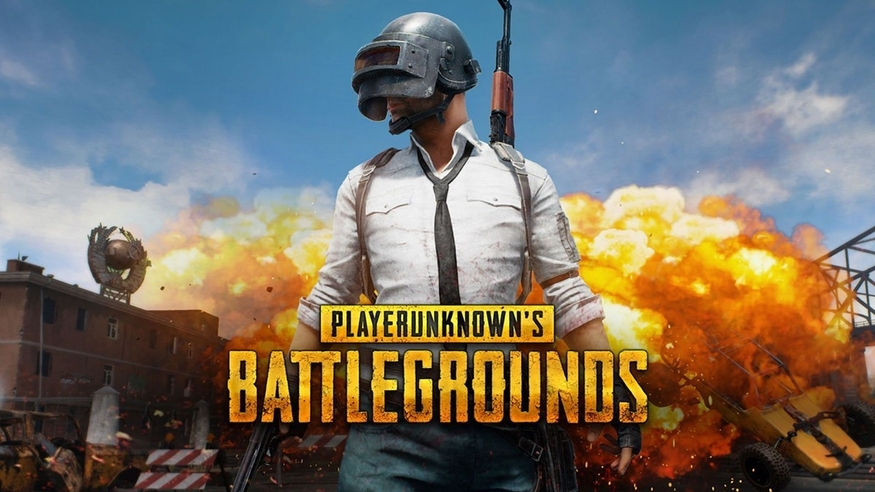

# PUBG가 뭐죠??
**PlayerUnknown’s BattleGround(PUBG)**는 우리나라의 게임 기업인 Bluehole의 자회사 PUBG Corporation에서 개발한 배틀로얄 게임입니다.  
일본 영화 배틀로얄에서 영감을 받아 만들어졌다고 하며, 외딴 섬에서 최대 100명의 플레이어가 점점 좁아지는 경기 구역에서 전략적으로 배치된 무기, 차량, 소모품 등을 찾아가며 최후의 1인을 가리는 생존전투를 하게됩니다.  

> PUBG는 유명한 게임 리뷰 회사인 IGN에서 10점 만점에서 9.5점의 평점을 받았고(Rad, 2018), 2017년 가장 많이 팔린 premium 게임이다(“2017 YEAR IN REVIEW: DIGITAL GAMES AND INTERACTIVE MEDIA”, 2018).


### Data Description
# 플레이어가 몇순위로 게임을 마칠 지 예측하기
### 게임 PUBG(Battle Gound)에서는 최대 100명의 플레이어가 경기를 시작합니다.  
### 탈락 시 매겨진 순위가 최종 순위가 됩니다.  
### 게임안에서 플레이어는 무기를 구하고 쓰러진 팀원들을 일으키고 차량을 운전하거나 수영, 달리기, 사격 등 생존을 위한 모든 것들을 경험합니다.  
### 각 row들은 한 플레이어가 게임을 하는동안 수집된 결과입니다.
### 데이터 안에는 솔로, 듀오, 스쿼드 등 최대 4인의 팀 경기가 포함되어있습니다.
### 우리가 이 데이터를 가지고 해야할 일은 1위부터 꼴찌까지의 통계를 가지고 **특정 플레이어가 몇순위로 게임을 마칠지 예측**하는 것입니다.

In [1]:
# 기본 모듈 import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
# base_path 지정
base_path = "/content/drive/MyDrive/Colab Notebooks/data/pubg-finish-placement-prediction/"

In [3]:
# train data 불러오기
train = pd.read_csv(base_path+'train_V2.csv')

In [4]:
# train data의 Column과 Dtype
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

# Columns Summary

-  Id : 플레이어의 아이디            
-  groupId : 경기 내 그룹 아이디(매 경기마다 새로생성) -> 어떤 팀에 속해있는지
-  matchId : 경기 아이디(이 row가 어떤 경기에서 나온 data인지 나타내는 값) -> training data와 test data내에는 서로 동일한 matchId가 없음 
-  assists : 자신이 처치한건 아니지만 팀원이 처치하는걸 도왔을 경우(어시스트)           
-  boosts : 부스트 아이템 사용횟수             
-  damageDealt : 자신이 가한 총 데미지(팀원이 준 피해나 자기 자신에게 가한 데미지는 제외)  
-  DBNOs : 다른 플레이어를 기절시킨 횟수(적 팀원에 의해 부활되어 처치횟수에는 포함되지않음)            
-  headshotKills : 헤드샷으로 처치한 횟수     
-  heals : 치유 아이템 사용횟수           
-  killPlace : 경기내 처치 횟수의 순위     
-  killPoints : 킬 수로 산정한 ELO의 개념. 만약 rankPoints에 -1 이외의 값이 있다면, killPoints의 0값은 값이 없는 것으로 처리됨.       
-  kills : 적 처치 수             
-  killStreaks : 짧은 시간동안 최대 처치 수(콤보 같은 개념)
-  longestKill : 가장 멀리서 처치한 거리      
-  matchDuration : 경기시간(초 단위)
-  matchType : 경기 유형 (solo, duo, squad, solo-fpp, duo-fpp, squad-fpp 등이 있으며 이외에도 이벤트나 커스텀 경기가 있음)      
-  maxPlace : 경기 내 가장 낮은 순위(꼴찌)
-  numGroups : 경기 내 그룹의 수 (solo -> duo -> squad로 갈수록 줄어듦)
-  rankPoints : 랭킹 ELO의 개념     
-  revives : 팀원을 소생시킨 횟수          
-  rideDistance : 탈것으로 이동한 거리
-  roadKills : 탈것으로 적을 처치한 횟수
-  swimDistance : 수영한 거리
-  teamKills : 팀원을 처치한 횟수
-  vehicleDestroys : 탈것을 폭발시킨 횟수
-  walkDistance : 걸어간 거리
-  weaponsAcquired : 무기 획득 횟수
-  winPoints : 승리 횟수로 산정한 ELO의 개념
-  winPlacePerc : 우리가 예측해야하는 값으로, 1에 가까워질 수록 순위가 올라가며 0부터 1까지 나타냄. 1의 경우 1순위, 0의경우 꼴찌를 의미.   

# ELO가 뭐죠?
체스에서 유래된 점수체계인데 딱 하나의 방식으로 정해진 것은 아니며 간단히 말해 승률을 책정하기 위한 점수라고 보면 될것 같습니다.  
점수를 산정하는 가중치의 경우 게임마다 달라집니다.

In [5]:
# train data 간략하게 살펴보기
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


## 한눈에 봐도 전처리가 필요해 보이는 column들
train.info()를 통해 확인한 결과 object 타입의 column이 몇개 있었는데  
그 중 Id, groupId, matchId의 경우 16진수로 입력되어 있는것같고  
matchType은 카테고리화 되어있으며,  
damageDeafult와 longestKill, rideDistance, swimDistance, walkDistance, winPlacePerc의 경우 소숫점으로 표현이 되어있습니다. 

In [6]:
train["Id"]

0          7f96b2f878858a
1          eef90569b9d03c
2          1eaf90ac73de72
3          4616d365dd2853
4          315c96c26c9aac
                ...      
4446961    afff7f652dbc10
4446962    f4197cf374e6c0
4446963    e1948b1295c88a
4446964    cc032cdd73b7ac
4446965    0d8e7ed728b6fd
Name: Id, Length: 4446966, dtype: object

In [7]:
train["groupId"]

0          4d4b580de459be
1          684d5656442f9e
2          6a4a42c3245a74
3          a930a9c79cd721
4          de04010b3458dd
                ...      
4446961    d238e426f50de7
4446962    408cdb5c46b2ac
4446963    e26ac84bdf7cef
4446964    c2223f35411394
4446965    8c74f72fedf5ff
Name: groupId, Length: 4446966, dtype: object

In [8]:
train["matchId"]

0          a10357fd1a4a91
1          aeb375fc57110c
2          110163d8bb94ae
3          f1f1f4ef412d7e
4          6dc8ff871e21e6
                ...      
4446961    18492834ce5635
4446962    ee854b837376d9
4446963    6d0cd12784f1ab
4446964    c9c701d0ad758a
4446965    62a16aabcc095c
Name: matchId, Length: 4446966, dtype: object

Id column의 경우 제거할수도 있지만 저는 분석할 내용이 있을것 같아서 남겨두도록 하겠습니다.  
다만 가독성을 위해 처리를 해주겠습니다........

In [ ]:
# 플레이어 Id가 겹치는 경우는 없음(한 플레이어의 플레이 기록이 2번 들어간 경우는 없음)
train["Id"].nunique()

4446966

In [ ]:
# 위에서부터 1번~4446966번으로 Id를 지정
# li_Id = list(train["Id"])

# for i in range(len(li_Id)):
#     train["Id"][i] = i+1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
# train.to_csv("/content/drive/MyDrive/Colab Notebooks/data/pubg-finish-placement-prediction/train_V3.csv")

In [ ]:
# train.head()

In [9]:
# 총 몇팀이 구성되었을까
train["groupId"].nunique()

2026745

In [10]:
# 총 몇경기가 데이터로 기록된걸까
train["matchId"].nunique()

47965

In [11]:
train.matchType

0          squad-fpp
1          squad-fpp
2                duo
3          squad-fpp
4           solo-fpp
             ...    
4446961    squad-fpp
4446962         solo
4446963    squad-fpp
4446964    squad-fpp
4446965     solo-fpp
Name: matchType, Length: 4446966, dtype: object

In [12]:
# 결측치 확인
train.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [13]:
# 결측치가 있는 행 확인
print(train[(train["winPlacePerc"].isnull() == True)])

                     Id         groupId         matchId  assists  boosts  \
2744604  f70c74418bb064  12dfbede33f92b  224a123c53e008        0       0   

         damageDealt  DBNOs  headshotKills  heals  killPlace  ...  revives  \
2744604          0.0      0              0      0          1  ...        0   

         rideDistance  roadKills  swimDistance  teamKills vehicleDestroys  \
2744604           0.0          0           0.0          0               0   

         walkDistance  weaponsAcquired  winPoints  winPlacePerc  
2744604           0.0                0          0           NaN  

[1 rows x 29 columns]


### 이 결측치를 어떻게 채워줄 것인가...
1. 해당 row를 삭제한다.
2. 평균값으로 채운다.
3. 중앙값으로 채운다.

In [14]:
# 평균값
train["winPlacePerc"].mean()

0.472821552721927

In [15]:
# 중앙값
train["winPlacePerc"].median()

0.4583

### Tip!!
팀단위 게임이기 때문에 킬수가 낮아도 순위는 높을 수 있다.  
따라서 학습을 시킬 때 개인별 데이터 보다는 **그룹별 통계치 (평균치)를 이용하여 학습**하는 것이 효율적일 것.  
